#What is arch model?
ARCH is an Autoregressive model with Conditional Heteroskedasticity .
“The ARCH process introduced by Engle (1982) explicitly recognizes the difference between the unconditional and the conditional variance allowing the latter to change over time as a function of past errors.”
Autoregressive: The current value can be expressed as a function of the previous values i.e. they are correlated.
Conditional: This informs that the variance is based on past errors.
Heteroskedasticity: This implies the series displays unusual variance (varying variance).

#Why an ARCH model?

#Autoregressive models can be developed for univariate time-series data that is stationary (AR), has a trend (ARIMA), and has a seasonal component (SARIMA). But, these Autoregressive models do not model is a change in the variance over time.

The error terms in the stochastic processes generating the time series were homoscedastic, i.e. with constant variance.

There are some time series where the variance changes consistently over time. 

In the context of a time series in the financial domain, this would be called increasing and decreasing volatility.

Volatility in Finance: Degree of variation price series over time as measured by the standard deviation of the series. Suppose that Si is the value of a variable on a day ‘i’. The volatility per day is the standard deviation of ln(Si /Si-1).

In time series where the variance is increasing in a systematic way, such as an increasing trend, this property of the series is called heteroskedasticity. This means changing or unequal variance across the series.

If this change in the variance can be correlated over time, then it can be modeled using an autoregressive process, such as ARCH.

#When to apply an ARCH model?

#In practice, this can be used to model the expected variance on the residuals after another autoregressive model has been used, such as an ARMA or similar.

Since we can only tell whether the ARCH model is appropriate or not by squaring the residuals and examining the correlogram, we also need to ensure that the mean of the residuals is zero.

Crucially, ARCH should only ever be applied to series that do not have any trends or seasonal effects, i.e. that have no (evident) serially correlation. ARIMA is often applied to such a series (or even Seasonal ARIMA), at which point ARCH may be a good fit.

#What is GARCH model?

Generalized Autoregressive Conditional Heteroskedasticity, or GARCH, is an extension of the ARCH model that incorporates a moving average component together with the autoregressive component.

Bollerslev (1986, Journal of Econometrics) generalized Engle’s ARCH model and introduced the GARCH model.

Introduction of moving average component allows the model:
To model the conditional change in variance over time.
Changes in the time-dependent variance.
Examples include conditional increases and decreases in the variance.

Thus GARCH is the “ARMA equivalent” of ARCH, which only has an autoregressive component. GARCH models permit a wider range of behavior more persistent volatility.

GACH Model of Order p, q — GARH(p,q):

GARCH(1,1):
Here we are going to consider a single autoregressive lag and a single “moving average” lag. The model is given by the following:
ϵ(t) = w(t) * σ(t)
ϵ(t) =w(t) * ⎷(⍺0 + ⍺1 *ϵ²(t-1)) + β1 * σ²(t−1)
Similarly GARH(p,q):
A time-series {ϵ(t)} is given at each instance by ϵ(t) = w(t)*σ(t)
and σ²(t) is given by:

source
where α(i) and β(j) are parameters of the model.
⍺0 > 0, ⍺i ≥ 0, i =1, … q, β≥ 0, j = 1, … p imposed to ensure that the conditional variances are positive.
Here we are adding moving average term, that is the value of σ² at t, σ²(t), is dependent upon previous σ²(t-j) values.
Interpretation:
The large value of β1 causes σ(t) to be highly correlated with σ²(t−1) and gives the conditional standard deviation process a relatively long-term persistence, at least compared to its behavior under an ARCH model.
For p = 0 the process reduces to the ARCH(q) process.
For p = q = 0, ϵ(t) is simply white noise.
How to configure the ARCH and GARCH Model(s):
The configuration for an ARCH model is best understood in the context of ACF and PACF plots of the variance of the time series.
This can be achieved by subtracting the mean from each observation in the series and squaring the result, or just squaring the observation if you’re already working with white noise residuals from another model.
The ACF and PACF plots can then be interpreted to estimate values for p and q, in a similar way as is done for the ARMA model.

#ARIMA-GARCH model for volatitlity forecasting

In [7]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.1 MB/s 


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [18]:
#this is the codeflow define an ARIMA or SARIMa model and then feed to residuals to the 
#garch model
#This function will generate the timseries
#importing the dataset
def generate_data(location:str,sample_number=10):
  data=pd.read_csv(location,engine='python')
  head=data.head()
  tail=data.tail()
  sample=data.sample(sample_number)
  description=data.describe()
  columns=data.columns 
  info=data.info()
  shape=data.shape
  size=data.size
  return {'data':data,'head':head,'tail':tail,'sample':sample,'description':description,'columns':columns,'info':info,
          'shape':shape,'size':size}


In [19]:
data_set=generate_data('/content/Electric_Production.csv')
data=data_set['data']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [21]:
#since some of the numeric fileds can be of type object therefore processing them and conveting to type float
def preproacessData(data):
  #except for the first column i.e date the data type of all the fields will be preprocessed
  for i in range(1,len(data.columns)):
    if data[data.columns[i]].dtype == object:
      #need to filter the string for some value:
      count=0
      for val in data[data.columns[i]]:
        string=""
        for char in val:
          #will only be appending the alphanumeric charcters since ?0.2 was giving an error
          if char.isdigit():
            string+=char
          
        data[data.columns[i]][count]=string
        count=count+1

      data[data.columns[i]] = data[data.columns[i]].astype('float64')
  return data

In [22]:
data=preproacessData(data)

In [27]:
#This is the arima model + it can be used with a non stationary dataset
#pass the order tuple after finding the best fit by running the get_best_fit function
def ARIMA_model(data,order,split:float=0.25):
  from math import ceil
  from statsmodels.tsa.arima.model import ARIMA
  divide = ceil(data.shape[0]*split)
  train=data[:data.shape[0]-divide]
  test=data[data.shape[0]-divide:]
  model=ARIMA(train[data.columns[1]],order=order)
  model=model.fit()
  model.summary()

  #visualizing the results and the model
  start=len(train)
  end=len(train)+len(test)-1
  pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
  pred.plot(legend=True)
  test[data.columns[1]].plot(legend=True)
  return model


  
  #the main task here is to figure out the order of ARIMA model  
  #this is done automatically using the pmdarima library
  #select the combination for which the AIC score is least
def give_best_fit(data,feature:str):
  from pmdarima import auto_arima
  stepwise_fit = auto_arima(data[feature], trace=True,suppress_warnings=True)

In [28]:
give_best_fit(data,data.columns[1])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2750.050, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2691.759, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2624.463, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2748.185, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2625.508, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2525.516, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2493.118, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2449.570, Time=0.49 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2449.577, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2431.710, Time=0.70 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2431.461, Time=0.47 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2359.635, Time=0.74 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2

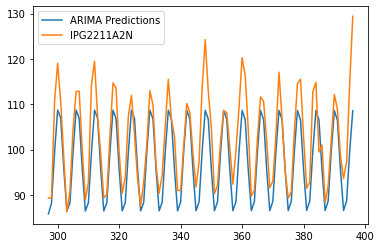

In [30]:
modelArima=ARIMA_model(data,(2,1,4))
#while calling the function the model will also be returned and then find the residual on this object
arima_residuals = modelArima.resid

In [ ]:
#SARIMA model for forecasting and then will return the model object to call in the residuals
#make sure that before working on this model you have your date as DateTimeObject
def SARIMA_model(data,start:int,end:int):
  import statsmodels.api as sm
  model=sm.tsa.statespace.SARIMAX(data[data.columns[0]],order=(1, 1, 1),seasonal_order=(1,1,1,12))
  results=model.fit()
  data['forecast']=results.predict(start=start,end=end,dynamic=True)
  data[[data.columns[1],'forecast']].plot(figsize=(12,8))
  
def getOrder(data):
  print('****************************************************')
  print('Damn this grid search takes a long time')
  print('Select the model with the least value of BIC')
  print('****************************************************')

  import itertools
  import statsmodels.api as sm
  ### Define Parameter Ranges to Test ###
  # Note: higher numbers will result in code taking much longer to run
  # Here we have it set to test p,d,q each = 0, 1 & 2
  # Define the p, d and q parameters to take any value between 0 and 3 (exclusive)
  p = d = q = range(0, 3)
  # Generate all different combinations of p, q and q triplets
  pdq = list(itertools.product(p, d, q))
  # Generate all different combinations of seasonal p, q and q triplets
  # Note: here we have 12 in the 's' position as we have monthly data
  # You'll want to change this according to your time series' frequency
  pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  result=sarimax_gridsearch(data,pdq, pdqs, maxiter=50, freq='M')  
  print(result)
  
  ### Run Grid Search ###
  # Note: this code will take a while to run
  # Define function

#ts is the data that you will be predicting upon
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):
  import statsmodels.api as sm
   # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
  ans = []
  for comb in pdq:
    for combs in pdqs:
      try:
        mod=sm.tsa.statespace.SARIMAX(ts[ts.columns[0]],order=comb,seasonal_order=combs)
        output = mod.fit(maxiter=maxiter) 
        ans.append([comb, combs, output.bic])
        print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
      except:
        print('except block is executed')
        continue
            
  ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
  ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
  return ans_df
    


def seasonalDecompsoe(data):
  from statsmodels.tsa.seasonal import seasonal_decompose
  decompose_data = seasonal_decompose(data, model="additive")
  decompose_data.plot();

def getSeasonality(data):
  from statsmodels.tsa.seasonal import seasonal_decompose
  decompose_data = seasonal_decompose(data, model="additive")
  #this plot is for seasonality if you want to extract seasonality only
  seasonality=decompose_data.seasonal
  seasonality.plot(color='green')

getOrder(data1)
#modify this function to return the fitted model and then calculate the residuals

In [ ]:
#Working on the GARCH model for the ARIMA residuals
#work on this model later on
#and check the second notebook on how to build a trade forecast